# Creates gif of the evolution of the training process
The plot contains two subplots
- Level sets of the predictions of the model at epoch
- Loss at epoch

In [31]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
import numpy as np

# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 


torch.backends.cudnn.deterministic = True
torch.manual_seed(2)
torch.cuda.manual_seed(2)

g = torch.Generator()
g.manual_seed(1)


# Data preparation

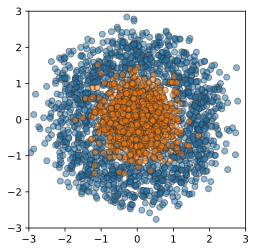

In [32]:
data_noise = 0.25
plotlim = [-3, 3]
subfolder = 'evo_circ'


from models.training import create_dataloader
dataloader, dataloader_viz = create_dataloader('circles', noise = data_noise, plotlim = plotlim)


In [33]:
#We can now conveniently access the data from the dataloaders
for X_test, y_test in dataloader_viz:
    print(X_test[:10], y_test[:10])
    break
    

tensor([[ 0.4938, -0.0707],
        [ 0.6855, -1.7415],
        [ 1.2477,  1.0872],
        [-1.8499, -0.5650],
        [ 0.9127, -0.1283],
        [-0.0226, -1.1892],
        [ 1.0594,  1.5573],
        [-0.0610, -0.6764],
        [-0.3784,  0.6913],
        [ 0.6060,  0.2134]]) tensor([1, 0, 0, 0, 1, 1, 0, 1, 1, 1])


# Model dynamics

In [34]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE

#for neural ODE based networks the network width is constant. In this example the input is 2 dimensional
hidden_dim, data_dim = 2, 2 
augment_dim = 0

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 3, 3 
bound = 0.
fp = False #this recent change made things not work anymore
cross_entropy = True
turnpike = False

non_linearity = 'tanh' #'relu' #
architecture = 'inside' #outside



torch.manual_seed(2)
torch.cuda.manual_seed(2)
anode = NeuralODE(device, data_dim, hidden_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-3) 


print(anode)

NeuralODE(
  (flow): Semiflow(
    (dynamics): Dynamics(
      (non_linearity): Tanh()
      (fc2_time): Sequential(
        (0): Linear(in_features=2, out_features=2, bias=True)
        (1): Linear(in_features=2, out_features=2, bias=True)
        (2): Linear(in_features=2, out_features=2, bias=True)
      )
    )
  )
  (linear_layer): Linear(in_features=2, out_features=2, bias=True)
  (non_linearity): Tanh()
)


In [35]:
torch.manual_seed(2)
torch.cuda.manual_seed(2)
rnode = NeuralODE(device, data_dim, hidden_dim, augment_dim=0, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_rnode = torch.optim.Adam(rnode.parameters(), lr=1e-3) 


print(rnode)

NeuralODE(
  (flow): Semiflow(
    (dynamics): Dynamics(
      (non_linearity): Tanh()
      (fc2_time): Sequential(
        (0): Linear(in_features=2, out_features=2, bias=True)
        (1): Linear(in_features=2, out_features=2, bias=True)
        (2): Linear(in_features=2, out_features=2, bias=True)
      )
    )
  )
  (linear_layer): Linear(in_features=2, out_features=2, bias=True)
  (non_linearity): Tanh()
)


# Training and generating level sets

In [36]:
from models.training import Trainer, doublebackTrainer
import imageio, os
from plots.plots import train_to_classifier_imgs

num_epochs = 30 #number of optimization runs in which the dataset is used for gradient decent
plotfreq = 5


trainer_anode = doublebackTrainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps = 0, eps_comp = 0.2) 

   
train_to_classifier_imgs(anode, trainer_anode, dataloader, subfolder, num_epochs, plotfreq)

0.2

Iteration 0/45
Loss: 0.715
Robust Term Loss: 0.087
Accuracy: 0.594

Iteration 10/45
Loss: 0.763
Robust Term Loss: 0.076
Accuracy: 0.516

Iteration 20/45
Loss: 0.749
Robust Term Loss: 0.079
Accuracy: 0.578

Iteration 30/45
Loss: 0.706
Robust Term Loss: 0.074
Accuracy: 0.578

Iteration 40/45
Loss: 0.668
Robust Term Loss: 0.070
Accuracy: 0.641
Epoch 1: 0.717
0.2

Iteration 0/45
Loss: 0.687
Robust Term Loss: 0.070
Accuracy: 0.609

Iteration 10/45
Loss: 0.734
Robust Term Loss: 0.063
Accuracy: 0.547

Iteration 20/45
Loss: 0.719
Robust Term Loss: 0.066
Accuracy: 0.609

Iteration 30/45
Loss: 0.689
Robust Term Loss: 0.062
Accuracy: 0.609

Iteration 40/45
Loss: 0.658
Robust Term Loss: 0.060
Accuracy: 0.688
Epoch 2: 0.696
0.2

Iteration 0/45
Loss: 0.671
Robust Term Loss: 0.061
Accuracy: 0.625

Iteration 10/45
Loss: 0.713
Robust Term Loss: 0.056
Accuracy: 0.562

Iteration 20/45
Loss: 0.699
Robust Term Loss: 0.059
Accuracy: 0.625

Iteration 30/45
Loss: 0.678
Robust Term Loss: 0.055
Accuracy: 0

In [37]:
from models.training import Trainer, doublebackTrainer
import imageio, os


trainer_rnode = doublebackTrainer(rnode, optimizer_rnode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps = 0.2) 



train_to_classifier_imgs(rnode, trainer_rnode, dataloader, subfolder, num_epochs, plotfreq, filename = 'rob')

0.2

Iteration 0/45
Loss: 0.659
Robust Term Loss: 0.087
Accuracy: 0.594

Iteration 10/45
Loss: 0.686
Robust Term Loss: 0.076
Accuracy: 0.516

Iteration 20/45
Loss: 0.677
Robust Term Loss: 0.078
Accuracy: 0.578

Iteration 30/45
Loss: 0.636
Robust Term Loss: 0.072
Accuracy: 0.578

Iteration 40/45
Loss: 0.603
Robust Term Loss: 0.068
Accuracy: 0.672
Epoch 1: 0.648
0.2

Iteration 0/45
Loss: 0.614
Robust Term Loss: 0.067
Accuracy: 0.609

Iteration 10/45
Loss: 0.643
Robust Term Loss: 0.059
Accuracy: 0.562

Iteration 20/45
Loss: 0.635
Robust Term Loss: 0.061
Accuracy: 0.609

Iteration 30/45
Loss: 0.607
Robust Term Loss: 0.055
Accuracy: 0.625

Iteration 40/45
Loss: 0.581
Robust Term Loss: 0.052
Accuracy: 0.703
Epoch 2: 0.614
0.2

Iteration 0/45
Loss: 0.587
Robust Term Loss: 0.052
Accuracy: 0.672

Iteration 10/45
Loss: 0.614
Robust Term Loss: 0.047
Accuracy: 0.641

Iteration 20/45
Loss: 0.609
Robust Term Loss: 0.048
Accuracy: 0.625

Iteration 30/45
Loss: 0.589
Robust Term Loss: 0.043
Accuracy: 0

# Loss plots

trainer_rnode.eps = 0.2
epoch = 5


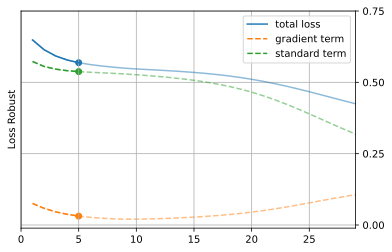

no filename given


In [38]:
from enum import auto

from plots.plots import loss_evolution
print(f'{trainer_rnode.eps = }')
loss_evolution(trainer_rnode, 5)

epoch = 5


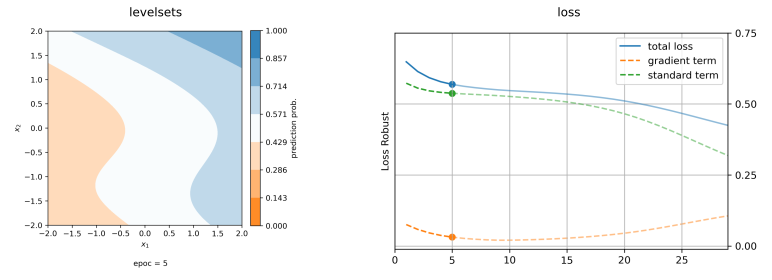

In [40]:
from plots.plots import comparison_plot

epoch = 5
fig_name_base = os.path.join(subfolder, '')
loss_evolution(trainer_rnode, epoch, 'loss_pic')
comparison_plot(fig_name_base + str(epoch) + '.png', 'levelsets', 'loss_pic.png', 'loss', 'test', show = True, figsize = (12,4))

## gif generation

In [41]:
from plots.gifs import evo_gif
gif = evo_gif(trainer_anode, num_epochs, plotfreq, subfolder, '')

5
epoch = 5
10
epoch = 10
15
epoch = 15
20
epoch = 20
25
epoch = 25
30
epoch = 30
evo_circ/evo.gif  created


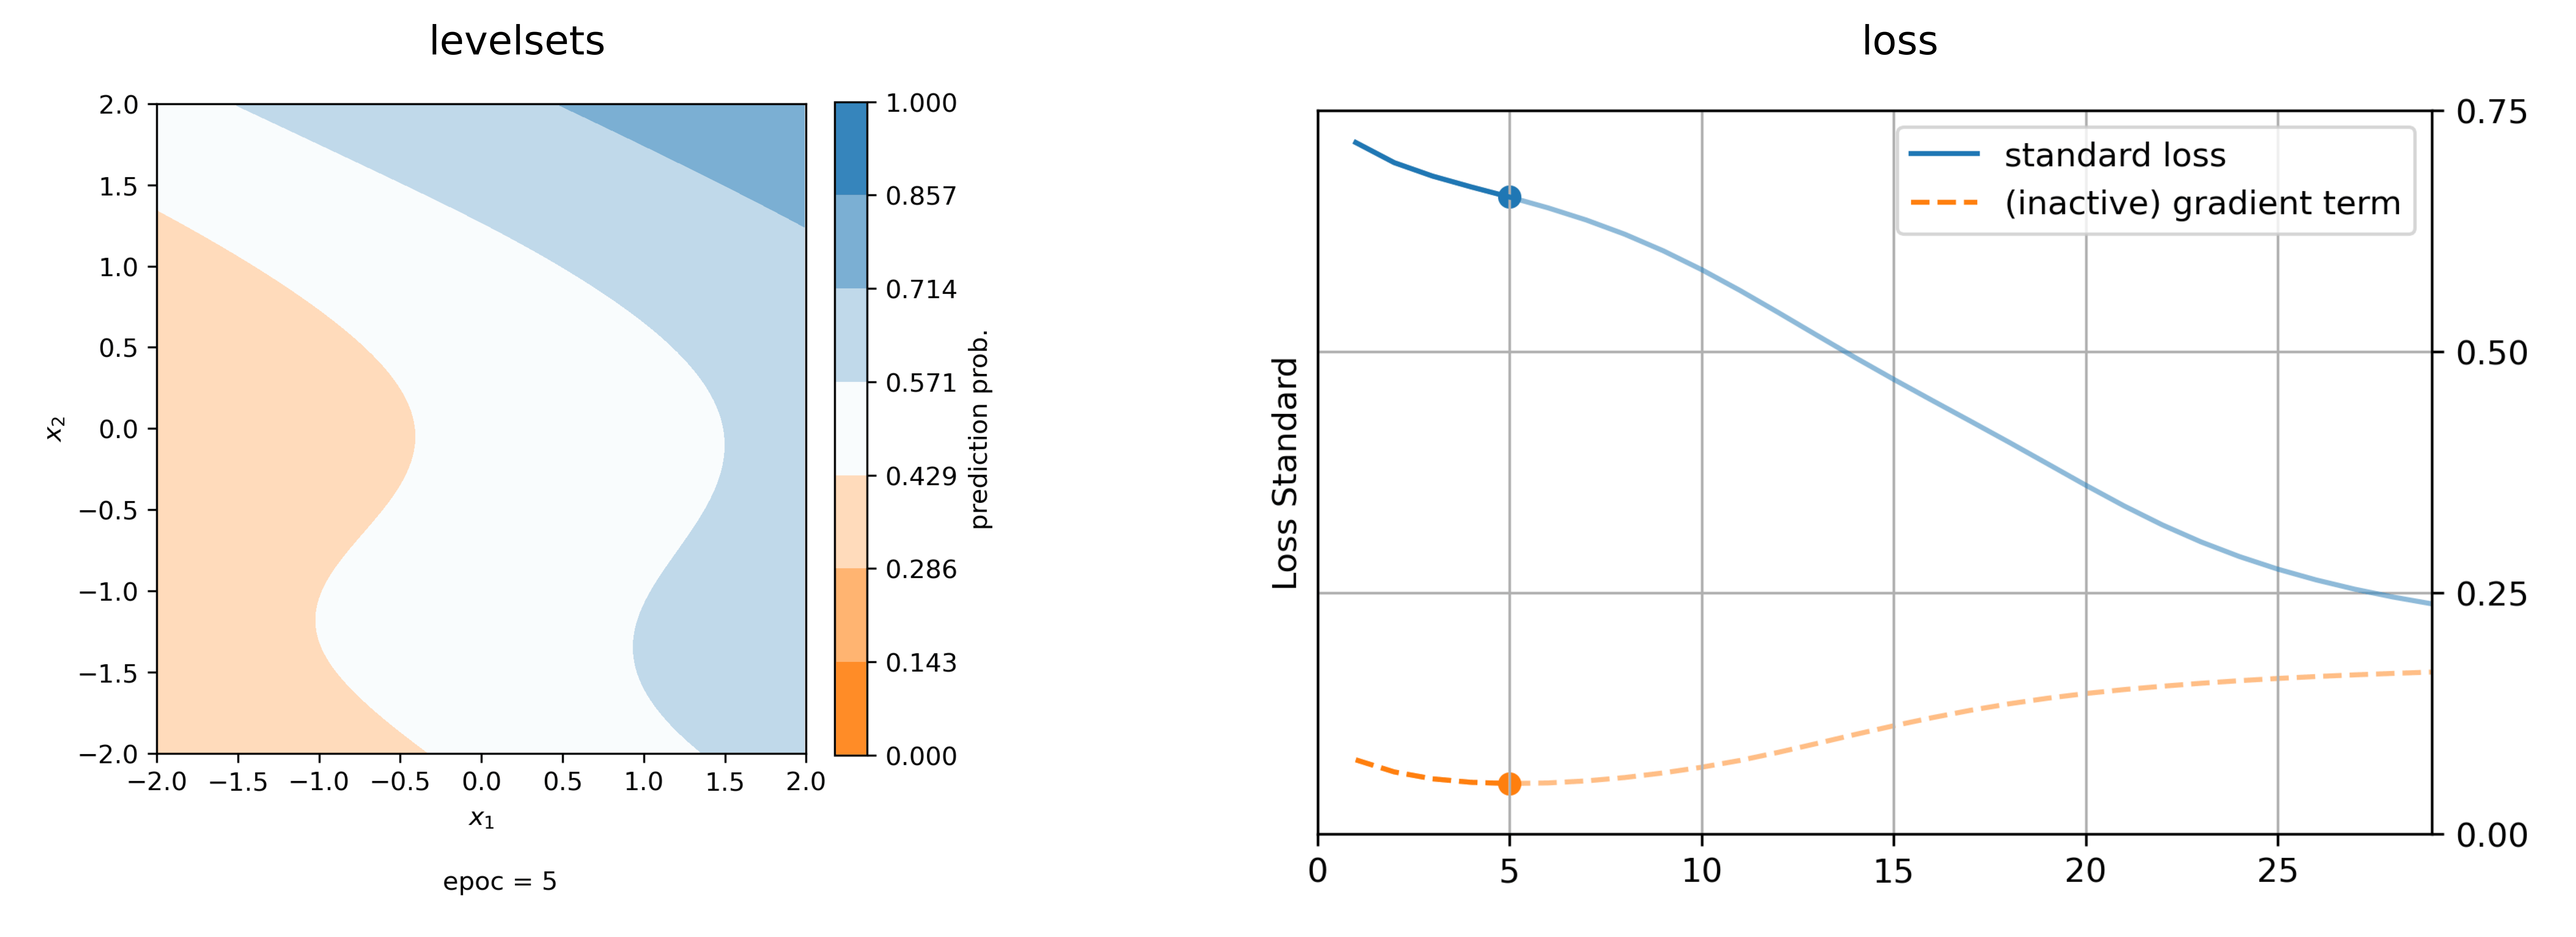

In [42]:
from IPython.display import Image
Image(filename = gif, width = 800)

5
epoch = 5
10
epoch = 10
15
epoch = 15
20
epoch = 20
25
epoch = 25
30
epoch = 30
evo_circ/robevo.gif  created


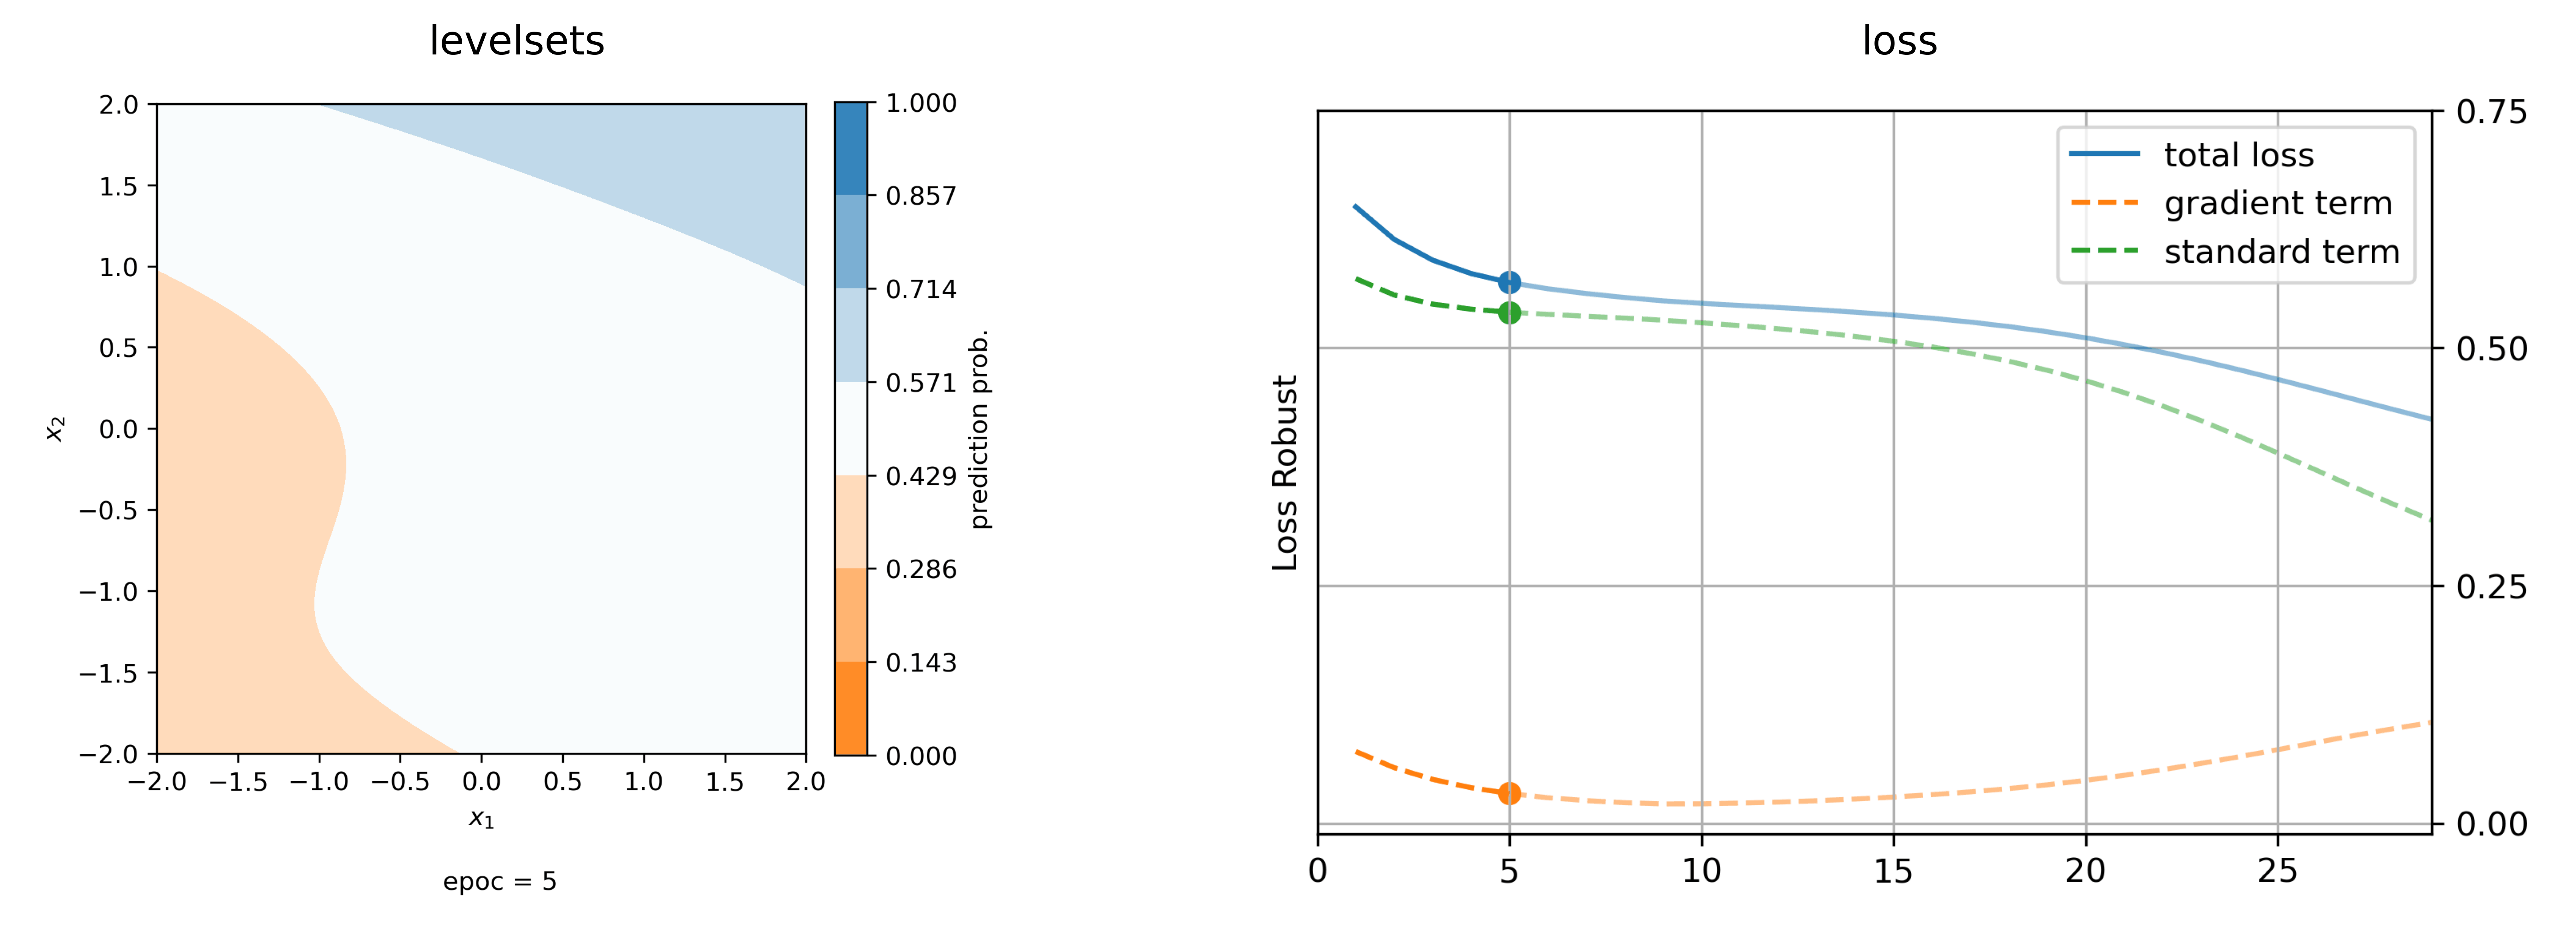

In [43]:
rob_gif = evo_gif(trainer_rnode, num_epochs, plotfreq, subfolder, 'rob')

from IPython.display import Image
Image(filename = rob_gif, width = 800)